In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import os
import h5py

In [ ]:
!pip install mahotas # Fast Computer Vision Algorithms Package using C++

     |████████████████████████████████| 5.7 MB 2.7 MB/s 


In [ ]:
import mahotas

In [ ]:
images_per_class       = 800
fixed_size             = tuple((500, 500))
train_path             = "/content/drive/MyDrive/dataset/train"
h5_train_data          = '/content/drive/MyDrive/dataset/output/train_data.h5'
h5_train_labels        = '/content/drive/MyDrive/dataset/output/train_labels.h5'
bins                   = 8

In [ ]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [ ]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [ ]:
# Image Segmentation for Extraction of Green and Brown color


def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])
    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)
    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])
    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)
    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
    return final_result

In [ ]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# feature-descriptor-2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [ ]:
# feature-descriptor-3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [ ]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['diseased', 'healthy']


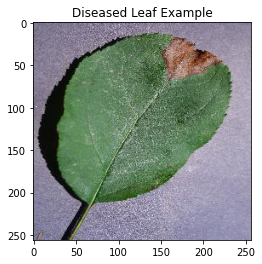

In [60]:
import matplotlib.image as mpimg
image_diseased = mpimg.imread("/content/drive/MyDrive/dataset/train/diseased/3.jpg")
plt.title("Diseased Leaf Example")
plt.imshow(image_diseased)


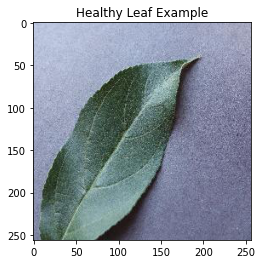

In [61]:
image_healthy = mpimg.imread("/content/drive/MyDrive/dataset/train/healthy/3.jpg")
plt.title("Healthy Leaf Example")
plt.imshow(image_healthy)

In [ ]:
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        
        # Running Function Bit By Bit
        
        RGB_BGR       = rgb_bgr(image)
        BGR_HSV       = bgr_hsv(RGB_BGR)
        IMG_SEGMENT   = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Feature Descriptors
        
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick   = fd_haralick(IMG_SEGMENT)
        fv_histogram  = fd_histogram(IMG_SEGMENT)
        
        # Concatenate 
        
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
        
        

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")

[STATUS] processed folder: diseased
[STATUS] processed folder: healthy
[STATUS] completed Global Feature Extraction...


In [ ]:
# Encode The Target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("training labels encoded...!")

training labels encoded...!


In [ ]:
# Scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler # Could use Standard Scaler too!
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("feature vector normalized...")

feature vector normalized...


In [48]:
print(global_features)

[[0.89725607 0.04666728 0.06195391 ... 0.01058887 0.12693291 0.96573218]
 [0.96735142 0.0021782  0.         ... 0.01055343 0.12657836 0.96564153]
 [0.96078906 0.01914876 0.01714926 ... 0.01058888 0.12693284 0.96573216]
 ...
 [0.98101076 0.00198514 0.0592025  ... 0.01058919 0.12706366 0.96573282]
 [0.96234885 0.00945362 0.         ... 0.010591   0.12704917 0.96571014]
 [0.95720605 0.03228463 0.09107748 ... 0.01058886 0.12693258 0.96573218]]


In [ ]:
# Save the feature vectors using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1600, 532), type "<f8">

In [ ]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (1600,), type "<i8">

In [ ]:
h5f_data.close()
h5f_label.close()

In [25]:
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.20
seed      = 9
train_path = "/content/drive/MyDrive/dataset/train"
test_path  = "/content/drive/MyDrive/dataset/test"
h5_train_data    = '/content/drive/MyDrive/dataset/output/train_data.h5'
h5_train_labels  = '/content/drive/MyDrive/dataset/output/train_labels.h5'
scoring    = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("Features shape: {}".format(global_features.shape))
print("Labels shape: {}".format(global_labels.shape))

print("Training Started...")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Features shape: (1600, 532)
Labels shape: (1600,)
Training Started...


In [26]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape)) 

[STATUS] splitted train and test data...
Train data  : (1280, 532)
Test data   : (320, 532)


In [27]:
trainDataGlobal

array([[0.97973956, 0.        , 0.        , ..., 0.01058888, 0.12693628,
        0.96573219],
       [0.90470961, 0.03308547, 0.03047729, ..., 0.01058886, 0.12692807,
        0.96573214],
       [0.92166131, 0.01766604, 0.03559807, ..., 0.01058994, 0.12737134,
        0.96573262],
       ...,
       [0.77039234, 0.        , 0.        , ..., 0.01058886, 0.12693296,
        0.96573218],
       [0.96965597, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.96574232],
       [0.98389776, 0.19183335, 0.15462199, ..., 0.01058898, 0.12695993,
        0.96573136]])

LR: 0.919531 (0.020978)
LDA: 0.904687 (0.024156)
KNN: 0.922656 (0.030748)
CART: 0.917188 (0.031484)
RF: 0.955469 (0.019469)
NB: 0.855469 (0.021608)
SVM: 0.915625 (0.022317)


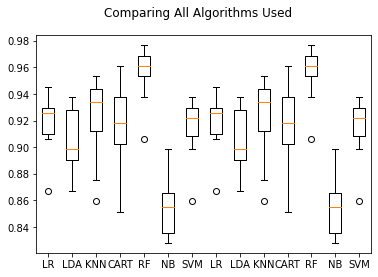

In [29]:
import matplotlib.pyplot as plt

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparing All Algorithms Used')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [30]:
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

In [31]:
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [32]:
y_predict=clf.predict(testDataGlobal)

In [33]:
y_predict

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [34]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

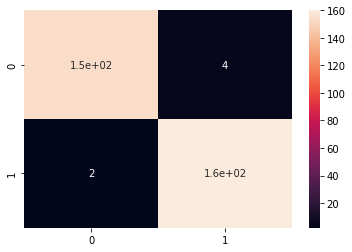

In [35]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy_score(testLabelsGlobal, y_predict)

0.98125